# IMDB case study - sinlge CNN solution

- The script is part of various methods evaluation for sentiment analysis using IMDB dataset
- In this script neural netowrk is based on single convolutional layer accompanied withe several dense layers
- the **accuracy** obtained is **0.8966**, with quite symmetric distribution of mistakes
- duration of network training (with early stopping based on eval loss) using full training set 
(25000, 4/5 for training, 1/5 for evaluation) is ~3 minutes using a single 2080Ti card

## **Dataset description**
- the datasource was acquired from Kaggle  https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset/version/1, and contains 50000 reviews for binary classification
- the core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). 
- Among all files provided, only revews texts were used, skipping  sentiment intensity information, source url and other attributes of reviews

## **Data loading**
- positive and negative reviews are stored in separated text files
- datasets for train, test, positive and negative reviews are stored in a single dictionary of four lists

In [1]:
import copy
import itertools
import multiprocessing
import os
import pickle
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import gensim
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import sklearn
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

import pandas as pd

from bs4 import BeautifulSoup

import datetime as dt

from joblib import Parallel, delayed
import multiprocessing
from tensorflow.keras.utils import Sequence

os.environ["CUDA_VISIBLE_DEVICES"]="1" 
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true" # allows to use the same GPU by more than one process
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK, pyll
from copy import deepcopy
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.utils import Sequence
from gensim.models.word2vec import Word2Vec
from sklearn import utils
import numpy as np
from tabulate import tabulate

%matplotlib inline
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

print("Versions:\nTensorflow: {}, Scikit-learn: {}, NLTK: {}\n"       "Gensim: {}, Pandas: {}, NumPy: {}\n".format(
          tf.__version__, sklearn.__version__,nltk.__version__, 
          gensim.__version__, pd.__version__, np.__version__))

Versions:
Tensorflow: 1.14.0, Scikit-learn: 0.21.2, NLTK: 3.4.4
Gensim: 3.4.0, Pandas: 0.25.0, NumPy: 1.17.2



In [2]:
NUM_CORES = multiprocessing.cpu_count() // 2

# suporting methods to pickle objects to file
def save_obj(obj, filename:str ):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(filename:str ):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [3]:
basedir="S://Python//CaseStudies//datasets//aclImdb//"
dirs={}
dirs[('train','pos')]=basedir+"train//pos//"
dirs[('train','neg')]=basedir+"train//neg//"
dirs[('test','pos')]=basedir+"//test//pos//"
dirs[('test','neg')]=basedir+"//test//neg//"

# loading texts to list stored in a single dictionary
texts={}
for d in dirs:
    texts[d]=[]
    for t in os.listdir(dirs[d]):
        f=open(file=dirs[d]+t,mode="r",encoding="utf-8")
        texts[d].append(f.read())
print("Loaded datasets")
for d in texts:
    print('Dataset: {}:{}, number of texts: {}'.format(d[0],d[1],len(texts[d])))
    

Loaded datasets
Dataset: train:pos, number of texts: 12500
Dataset: train:neg, number of texts: 12500
Dataset: test:pos, number of texts: 12500
Dataset: test:neg, number of texts: 12500


## **Data preprocessing**
**Assumptions**
> - classifiers must be used with unseen data. Test data cannot be used as training or validation set.
> - Therefore among 25000 train records 4/5 will be used for training, and remaining 5000 will be used as validationset
> - The **real performance** of the classifier will be evaluated using the whole test set

**Supporting functions for text preprocessing**
- html tags and unicode dropping
- repeated letters or special characters replacement
- symbolic chars with special meaning replacement such as "&"="and"
- contractions replacement i.e. "don't" = "do not"
- numbers replacement
- special characters removal
- stopwords removal
- stemming or lemmatization
- negation identifying and marking

**Potentially benefitial, but not included in preprocessing**
- replace negations with single word synonyms
- spelling corrections

In [4]:
def drop_html_and_unicode(text:str)->str:
    """
    Dropping html and unicode characters
    """
    # strip HTML tags
    text=BeautifulSoup(markup=text,features="lxml").text
    # strip unicode characters
    text = re.sub(pattern=r'(\\u[0-9A-Fa-f]+)',repl=r'',string=text)
    text = re.sub(pattern=r'[^\x00-\x7f]',repl=r'',string=text)
    # strip urls
    text = re.sub(pattern=r'((www\.[A-Za-z0-9_\-\.]+))',repl=r'url', string=text,)
    text = re.sub(pattern=r'((https?://[A-Za-z0-9_\-\.]+))',repl=r'url', string=text,)
    return text


def replace_repetitions(text:str)->str:
    """
    replacing repetitions of letters and special characters
    """
    # replace any repetition longer than 2 with exactly 2 occurences
    text=re.sub(pattern=r"(.)\1{2,}",repl=r"\1\1",string=text)
    # replace repetitions of special characters with a single occurence
    text=re.sub(pattern=r"([\!,\?\. ])\1{1,}",repl=r"\1",string=text)
    return text


def replace_symbolic_chars(text:str)-> str:
    """
    replacing special meaning of alone & and |
    """
    # in fact this step is only necessary for some approaches. It is not if stop words will be removed in one of the following steps.
    text=re.sub(pattern=r"([ ,]\&[ ,])",repl=" and ",string=text) # assume there are spaces around &
    text=re.sub(pattern=r"([ ,]\|[ ,])",repl=" or ",string=text) # assume there are spaces around pipe
    return text

def replace_contractions(text:str)->str:
    contractions_replacement_dict={
    # contractions with not were identified from documents
    # some rare contractions or mistakes were skipped
        r"don't":" do not ", r" doesn't ":" does not " , r" didn't ":" did not ",
        r"can't":" can not ", r"isn't":" is not ", r"wasn't":" was not ",
        r"couldn't":" could not ", r"won't":" will not ", r"wouldn't":" would not ",
        r"aren't":" are not ", r"haven't":" have not ", r"weren't":" were not ",
        r"hasn't":" has not ", r"shouldn't":" should not ", r"hadn't":" had not ",
        r"ain't":" it is not ", r"needn't":" need not ", r"mustn't":" must not ",
        r"dosen't":" does not ", r"shan't":" shall not ", r"wan't":" was not ",
        r"Weren't":" were not ", r"Musn't":" must not ", r"arn't":" are not ",
        r"havn't":" have not ", r"Doesen't":" does not ", r"an't":" are not ",
        r"Idon't":" I do not ", r"Shudn't":" should not ", r"dosn't":" does not ",
        r"doeesn't":" does not ", r"heaven't":" have not ", r"doen't":" does not ",    
        r"din't":" did not ", r"wqasn't":" was not ", r"mightn't":" might not ",
        r"hasen't":" has not ", r"shoudln't":" should not ", r"wern't":" were not ",
        r"wouln't":" would not ", r"doesen't":" does not ",
    # other contractions
        r"i'm":" i am ", r"(\w+)\'ll":"\g<1> will ",r"(\w+)\'ve":"\g<1> have ",
        r"(\w+)\'s":"\g<1> is ",r"(\w+)\'re":"\g<1> are ",r"(\w+)\'d":"\g<1> would "}
        # replaced contraction is surrounded with spaces to correct contraction joined with preceding word
    for p in contractions_replacement_dict.keys():
        text=re.sub(pattern=p,repl=contractions_replacement_dict[p],string=text,flags=re.IGNORECASE)
    # duplicated spaces removal
    text=re.sub(pattern="( )+",repl=" ",string=text)
    return text

def drop_numbers(text:str)->str:
    # any integer number is wiped off
    return ''.join([x for x in text if not x.isdigit()])   


def drop_special_chars(text: str)->str:
    # some punctuation chars, used by mark_stopwords are not removed by this method to avoid 
    # negative influence on negation scope detection. 
    # The mark_negation method limits scope to one of the following: '^[.:;!?]$' . 
    # So they remain untouched'
    text=re.sub(pattern=r"[^\w^ .:;!?]",repl="",string=text)  
    text=re.sub(pattern="( )+",repl=" ",string=text)
    return text

def remove_stopwords(s:str)->str:
    # stopword list were inherited from NLTK.
    # words important from the poin of view of negation detection were eliminated
    stopwords=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 
           'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 
           'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 
           'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 
           'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 
           'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 
           'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
           'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 
           'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 
           'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 
           'most', 'other', 'some', 'such', 'nor', 'own', 'same', 'so', 'than',  'very', 's', 't', 
           'can', 'will', 'just', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 
           'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
           'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', 
           "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
           'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    return ' '.join([w for w in word_tokenize(s) if w.lower() not in stopwords])

def perform_stemming(text:str)->str:
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(s) for s in word_tokenize(text)])

def perform_lemmatization(text:str)->str:
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(s) for s in word_tokenize(text)])


def tokenize_with_negations(text:str)->str:
    # marking negative words and finally eliminating remaining punctuation
    # what is important - this method should be used as last.
    # it returns text tokenized
    # Surrounding stop mark with spaces is also important to get rid of problem with 
    # stop mark connected with the following word.
    text=mark_negation([x for x in word_tokenize(re.sub(pattern=r"\.",repl=" . ",string=text))])
    text=[x for x in text if x not in ['.',':',';','!','?','no','not']]
    return text

In [5]:
def perform_text_cleanup_for_NN(text:str)->str:
    text=drop_html_and_unicode(text)
    text=replace_repetitions(text)
    text=replace_symbolic_chars(text)
    text=drop_numbers(text)
    text=replace_contractions(text)
    text=perform_lemmatization(text)
    text=drop_special_chars(text)
    text=text.lower()
    return text

texts_after_cleanup={}
start=dt.datetime.now()
for d in texts.keys():
    texts_after_cleanup[d]=Parallel(n_jobs=NUM_CORES)(delayed(perform_text_cleanup_for_NN)(s) for s in texts[d])
print('Texts cleanup finished in {}'.format(dt.datetime.now()-start))

# merging data
n_train_reviews=25000
n_test_reviews=25000

# train data preparation
train_data_pos=pd.DataFrame(texts_after_cleanup[('train','pos')])
train_data_pos['Sentiment']=1
train_data_neg=pd.DataFrame(texts_after_cleanup[('train','neg')])
train_data_neg['Sentiment']=0
train_data=train_data_pos.append(train_data_neg)
train_data.reset_index(inplace=True,drop=True)
train_data.columns=['Review','Sentiment']
train_data=shuffle(train_data)
train_data=train_data[:n_train_reviews]

#test data preparation
test_data_pos=texts_after_cleanup[('test','pos')]
test_data_neg=texts_after_cleanup[('test','neg')]
test_data=pd.DataFrame([(s,1) for s in test_data_pos]+[(s,0) for s in test_data_neg])
test_data.columns=['Review','Sentiment']
test_data=shuffle(test_data)
test_data=test_data[:n_test_reviews]

print("Storing reviews in two dataframes with shapes: train_data: {}, test_data: {}" \
      .format(train_data.shape, test_data.shape))
train_data.head(5)

Texts cleanup finished in 0:00:25.805499
Storing reviews in two dataframes with shapes: train_data: (25000, 2), test_data: (25000, 2)


,Review,Sentiment
14297,the acting in the film is really well done hon...,0
1251,the sopranos is arguably the greatest show in ...,1
8977,many review here explain the story and charact...,1
14746,that might be a bit harsh for me saying that b...,0
9083,the narrative affirms the classic image of goo...,1


## **Sequences preparation**


**Reviews lengths (in words) distributions (train subset)**

,0.50,0.75,0.80,0.90,0.95,0.97,0.98,0.99,1.00
Required padding,134,219,250,354,463,547,612,705,2068


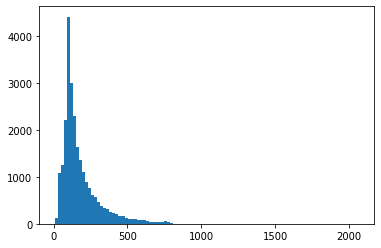

In [6]:
# skipped words shorter than 3 letters
from nltk.tokenize import word_tokenize
review_lengths=[len(s) for s in [[w for w in word_tokenize(x) if len(w)>2] for x in train_data['Review']]]
plt.hist(review_lengths,bins=100);
padding_sizes={}
for q in [0.5,0.75,0.8,0.9,0.95,0.97,0.98,0.99,1]:
    padding_sizes[q]=int(np.quantile(review_lengths,q))
pd.DataFrame.from_dict(padding_sizes, orient='index',columns=['Required padding']).T

<font color='red'>**global word embedding settings**</font>

In [7]:
EMBED_DIM=300 # embedding vector dimensions
VOCAB_SIZE=10000 # number of most frequent words used
PADDING_SIZE=612 # padding size to cover fully 95% of train and validation reviews 
SPLIT_POINT=20000 # use 4/5 as train set, 1/5 as validation set
BATCH_SIZE=128 # batch size for feeding models with sequences

**padded sequences preparation**

In [8]:
def prepare_sequences(vocab_size, padding_size, split_point, train_data, test_data):
    # split train and validation data. 
    # Tokenized must be fit only using train data
    # this is why split must be the first step
    val_data=train_data[split_point:].copy()
    train_data=train_data[:split_point].copy()
    print('Train data shape: {}, Validation data shape: {}'.format(train_data.shape,val_data.shape))

    # fit tokenizer and tokenize train, validation and test sets
    tokenizer=Tokenizer(num_words=vocab_size,oov_token='<OOV>')
    tokenizer.fit_on_texts(train_data['Review'])
    train_sequences=tokenizer.texts_to_sequences(train_data['Review'])
    val_sequences=tokenizer.texts_to_sequences(val_data['Review'])
    test_sequences=tokenizer.texts_to_sequences(test_data['Review'])

    # creating result dictionary
    results_dict={
        'vocab_size': vocab_size,
        'padding_size': padding_size,
        'split_point':split_point,
        'train_data':train_data,
        'val_data':val_data,
        'test_data':test_data,
        'tokenizer':tokenizer,
        'train_seq_pad': pad_sequences(train_sequences, maxlen=padding_size, padding='post', truncating='post'),
        'val_seq_pad' : pad_sequences(val_sequences, maxlen=padding_size, padding='post', truncating='post'),
        'test_seq_pad': pad_sequences(test_sequences, maxlen=padding_size, padding='post', truncating='post'),
        'train_labels':train_data['Sentiment'].values,
        'val_labels':val_data['Sentiment'].values,
        'test_labels': test_data['Sentiment'].values,
    }
    return results_dict



In [9]:
padded_sequences_dict=prepare_sequences(vocab_size=VOCAB_SIZE, 
                                        padding_size=PADDING_SIZE,
                                        split_point=SPLIT_POINT,
                                        train_data=train_data, 
                                        test_data=test_data)
print('Train, validation and test sequences prepared and stored as a dictionary')
# save datasets to be able to reuse
save_obj(padded_sequences_dict,'padded_sequences_dict.pkl')

Train data shape: (20000, 2), Validation data shape: (5000, 2)
Train, validation and test sequences prepared and stored as a dictionary


## **Training**

### Supporting staff

**sequence generator to feed models**
- due to the fact that Tensorflow native embeddings and Gensim models are going to be used, the generator was created in the way which allows to select wheather the outpu is in form of tokenized sequences or vectors.

In [10]:
MODE_TOKENS_ONLY=0
MODE_W2V_ONLY=1
MODE_TOKENS_AND_W2V=2

class ReviewsGenerator(Sequence):
    """
    Generator with combined tokens for embedding layer and Word2Vec representation
    @sequences : list of seqences, either train, val or test.Sequences must be padded
    @labels : list of labels for sequences provided
    @tokenizer : trained instance of tokenizer
    @model : instance of trained model (f.e w2v) or None if not used (MODE_TOKENS_ONLY)
    @batch_size : batch size to produce
    @mode: one of:
            MODE_TOKENS_ONLY - only lists of tokens are produced
            MODE_W2V_ONLY - embedding vectors are produced, @model cannot be None
            MODE_TOKENS_AND_W2V - embedding vectors and tokens  are produced, 
                                @model cannot be None
    Returns:
            MODE_TOKENS_ONLY: BATCH_SIZE x (tokenized sequence, label)
            MODE_W2V_ONLY: BATCH_SIZE x (embedding vector, label)
            MODE_TOKENS_AND_W2V: BATCH_SIZE x (tokenized sequence, embedding vector, label)
    """
    def __init__(self, sequences, labels, tokenizer, model, batch_size, mode):
        self.padded=sequences
        self.batch_size=batch_size
        self.labels=labels
        self.model=model
        self.tokenizer=tokenizer
        self.mode=mode
    
    def __len__(self):
        return int(np.ceil(len(self.padded))/float(self.batch_size))
    
    def __getitem__(self, idx):
        batch_x=self.padded[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y=self.labels[idx*self.batch_size:(idx+1)*self.batch_size]
        if self.mode==MODE_TOKENS_ONLY:
            return (batch_x, batch_y)
        else:
            tokens=np.array([[self.tokenizer.index_word[x] if x>0 else 
                              '' for x in elem]  for elem in batch_x])
            batch_x1=np.array([[self.model[x] if x in self.model.wv.vocab else 
                                np.zeros(self.model.vector_size, dtype='int') 
                                for x in elem] for elem in tokens])
            if self.mode==MODE_W2V_ONLY:
                return (batch_x1, batch_y)
            else:
                return (batch_x, batch_x1, batch_y)

**model train method**

In [12]:
def train_evaluate_model(w2v_model,
                         train_generator,val_generator,
                         max_epochs,max_no_improvement, verbose, plot_results=True, 
                         validation_evaluate=True):
    res={}
    start=dt.datetime.now()
    history=w2v_model.fit_generator(generator=train_generator, 
                                  epochs=max_epochs, 
                                  verbose=verbose,
                                  validation_data=val_generator,
                                  callbacks=[
                                      EarlyStopping(min_delta=1e-4, 
                                                    patience=max_no_improvement,
                                                    verbose=verbose, 
                                                    restore_best_weights=True)])

    if plot_results:
        # loss and accuracy progress for train and validation sets
        fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(24,6))
        sns.lineplot(x=[p for p in range(len(history.history['loss']))],
                     y=history.history['loss'],color='red',label='loss',ax=ax[0])
        sns.lineplot(x=[p for p in range(len(history.history['acc']))],
                     y=history.history['acc'],color='blue',label='accuracy',ax=ax[0])
        sns.lineplot(x=[p for p in range(len(history.history['loss']))],
                     y=history.history['val_loss'],color='red',label='loss',ax=ax[1])
        sns.lineplot(x=[p for p in range(len(history.history['val_acc']))],
                     y=history.history['val_acc'],color='blue',label='accuracy',ax=ax[1])
        sns.lineplot(x=[p for p in range(len(history.history['acc']))],
                     y=history.history['acc'],color='orange',ax=ax[2],label='train')
        sns.lineplot(x=[p for p in range(len(history.history['acc']))],
                     y=history.history['val_acc'],color='black',ax=ax[2],label='validation')
        ax[0].set_title('Train accuracy and loss')
        ax[1].set_title('validation accuracy and loss')
        ax[2].set_title('Accuracy comparison - training and validation')
        for x in ax:
            x.legend()
        plt.show()
    
    #evaluating results
    if validation_evaluate:
        eval_result=w2v_model.evaluate_generator(generator=val_generator)
    
    print('Validation set results: Loss: {:4f}, Accuracy: {:.4f}'.format(eval_result[0], eval_result[1]))
    duration=dt.datetime.now()-start
    print('Duration: {}'.format(duration))
    res['eval loss']=eval_result[0]
    res['eval_accuracy']=eval_result[1]
    res['training duration']=duration
    res['history']=history.history
    return res

**Results visualization**

In [59]:
def plot_dense_weights_distribution(model, dense_layers, figsize,grid_height_ratios,title):
    """
    @model: trained model
    @dense_layers: numbers of dense layers, list of numbers in a graph
    @figsize: target figure size including all axes, tuple
    @grid_height_ratios: list of proportions used for matplotlib.gridspec.GridSpec
    @title : string to put above the diagram
    """
    fig = plt.figure(frameon=False,figsize=figsize)
    gs = GridSpec(nrows=len(dense_layers)+3, ncols=len(dense_layers), figure=fig,height_ratios=grid_height_ratios)
    for ax_no,layer_no in enumerate(dense_layers):
        ax=fig.add_subplot(gs[ax_no,:])
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none')    
        ax.tick_params(labelbottom=False,labelleft=False)    
        wmap=model.layers[layer_no].get_weights()[1]
        if ax_no!=len(dense_layers)-1:
            sns.heatmap(wmap.reshape(1,len(wmap)),ax=ax, vmin=0,cbar_ax=None, cbar=False,cmap='tab20')
        else:
            ax1=fig.add_subplot(gs[ax_no+1,:])
            sns.heatmap(wmap.reshape(1,len(wmap)),ax=ax, vmin=0,cbar_ax=ax1,fmt='.4f',annot=True,cmap='tab20',cbar_kws={'orientation':'horizontal'})

        ax.set_ylabel(layer_no,fontsize=16)
        ax=fig.add_subplot(gs[6,ax_no])
        res=sns.distplot(a=wmap,hist=False,kde_kws={'color':'red','linewidth':3},ax=ax)
        ax.set_title(label='{}:{}'.format(layer_no,tf_native_model.layers[layer_no].name))
    fig.suptitle(title)
    
def plot_training_eval_results(iter_results:dict):
    """
    @iter_results: dictionary of training results
    """
    fig, ax= plt.subplots(ncols=2,nrows=1,figsize=(16,7),sharey=True)
    for niter in iter_results.keys():
        sns.lineplot(x=[p for p in range(len(results[niter]['history']['loss']))],
                         y=results[niter]['history']['loss'],color='red'.format(niter),ax=ax[0])
        sns.lineplot(x=[p for p in range(len(results[niter]['history']['acc']))],
                         y=results[niter]['history']['acc'],color='green'.format(niter),ax=ax[0])
        ax[0].set_title('Training accuracy and loss')
        sns.lineplot(x=[p for p in range(len(results[niter]['history']['val_loss']))],
                     y=results[niter]['history']['val_loss'],color='red'.format(niter),ax=ax[1])
        sns.lineplot(x=[p for p in range(len(results[niter]['history']['val_acc']))],
                         y=results[niter]['history']['val_acc'],color='green'.format(niter),ax=ax[1])
        ax[1].set_title('Validation accuracy and loss')
    evaldata=pd.DataFrame.from_dict({x:{'val loss':iter_results[x]['eval loss'],
                                        'val accuracy':iter_results[x]['eval_accuracy'],
                                        'training duration':iter_results[x]['training duration']} 
                                     for x in iter_results}).T
    print('Average results:')
    print(tabulate(pd.DataFrame(evaldata.mean(axis=0)).reset_index(),headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))    
    for c in evaldata.columns[:-1]:
        evaldata[c]=evaldata[c].apply(lambda x: float(x))
    print('Validation results for each iteration:')
    print(tabulate(pd.pivot_table(evaldata.reset_index(),values=['val loss','val accuracy'],
                                  columns='index'),headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))
    return evaldata


### Model training and evaluation

In [26]:
global_results={}
global_models={}

In [27]:
# hyperparameters 
CONV1_filters=1024
CONV1_kernel_size=3
CONV1_kernel_rgularizer_L2_ratio=1e-6
CONV1_kernel_rgularizer_L1_ratio=1e-6

# training and evaluation
BATCH_SIZE=96
tf.reset_default_graph()
results={}
print_summary=True
for i in [0,1,2,3,4,5,6]:
    inputs=tf.keras.Input(shape=(PADDING_SIZE,),dtype=np.int32)
    stack=tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=PADDING_SIZE)(inputs)
    stack=tf.keras.layers.Conv1D(filters=CONV1_filters, 
                                 kernel_size=CONV1_kernel_size, 
                                 activation='elu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l1_l2(
                                     l1=CONV1_kernel_rgularizer_L1_ratio, 
                                     l2=CONV1_kernel_rgularizer_L2_ratio))(stack)

    stack=tf.keras.layers.GlobalMaxPooling1D()(stack)
    stack=tf.keras.layers.Dropout(rate=0.2)(stack)
    stack=tf.keras.layers.Dense(units=256, activation='relu')(stack)
    stack=tf.keras.layers.Dropout(rate=0.2)(stack)
    stack=tf.keras.layers.Dense(units=64, activation='relu')(stack)
    stack=tf.keras.layers.Dropout(rate=0.2)(stack)
    stack=tf.keras.layers.Dense(units=16, activation='relu')(stack)
    stack=tf.keras.layers.Dropout(rate=0.2)(stack)
    stack=tf.keras.layers.Dense(units=8, activation='relu')(stack)
    outputs=tf.keras.layers.Dense(units=1, activation='sigmoid')(stack)
    tf_native_model=tf.keras.Model(inputs=inputs, outputs=outputs, name='TF embeddings CNN')
    tf_native_model.compile(loss='binary_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(lr=1e-4, decay=1e-6),
                            metrics=['accuracy'])
    if print_summary:
        print(tf_native_model.summary())
        print_summary=False
    model_name="CNN_final_state_results_{}.pkl".format(i)
    print('\n',model_name)
    s_res=train_evaluate_model(w2v_model=tf_native_model,
                           train_generator=ReviewsGenerator(sequences=padded_sequences_dict['train_seq_pad'],
                                            labels=padded_sequences_dict['train_labels'],
                                            tokenizer=padded_sequences_dict['tokenizer'], 
                                            model=None, 
                                            batch_size=BATCH_SIZE,
                                            mode = MODE_TOKENS_ONLY), 
                           val_generator=ReviewsGenerator(sequences=padded_sequences_dict['val_seq_pad'],
                                            labels=padded_sequences_dict['val_labels'],
                                            tokenizer=padded_sequences_dict['tokenizer'], 
                                            model=None, 
                                            batch_size=BATCH_SIZE,
                                            mode = MODE_TOKENS_ONLY),
                           max_epochs=100,max_no_improvement=10, verbose=0,plot_results=False)
    results[i]=s_res
    global_models[i]=tf_native_model
    tf_native_model.save('models//'+model_name)
global_results[tf_native_model.name]=results

Model: "TF embeddings CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 612)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 612, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 612, 1024)         922624    
_________________________________________________________________
global_max_pooling1d (Global (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)         

Average results:
╒════╤═══════════════════╤════════════════════════╕
│    │ index             │ 0                      │
╞════╪═══════════════════╪════════════════════════╡
│  0 │ val loss          │ 0.2919419579781019     │
├────┼───────────────────┼────────────────────────┤
│  1 │ val accuracy      │ 0.8943738256181989     │
├────┼───────────────────┼────────────────────────┤
│  2 │ training duration │ 0 days 00:03:01.949367 │
╘════╧═══════════════════╧════════════════════════╛
Validation results for each iteration:
╒══════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│              │      0 │      1 │      2 │      3 │      4 │      5 │      6 │
╞══════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ val accuracy │ 0.8964 │ 0.8948 │ 0.8912 │ 0.8906 │ 0.8928 │ 0.8960 │ 0.8986 │
├──────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ val loss     │ 0.2838 │ 0.2832 │ 0.2856 │ 0.3023 │ 0.2844 │ 0.3235 │ 0.280

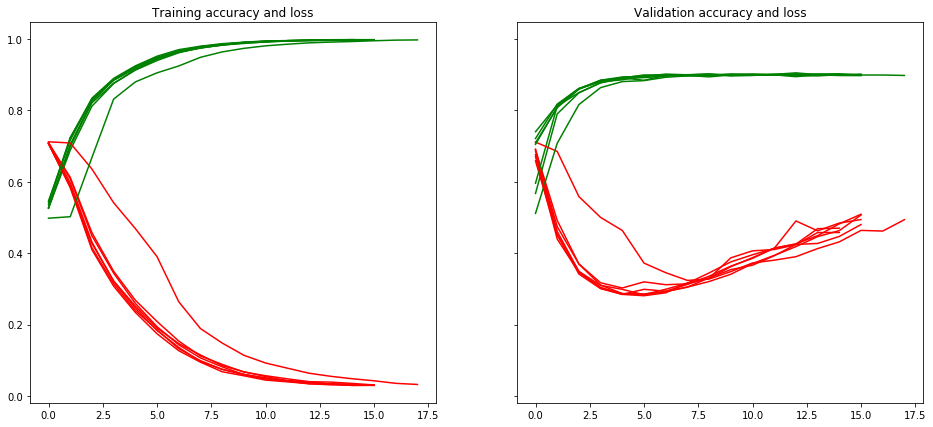

In [29]:
plot_training_eval_results(results)
save_obj(global_results,'00.IMDB_sentiment_with_CNN-Final-v.1.0.pkl')

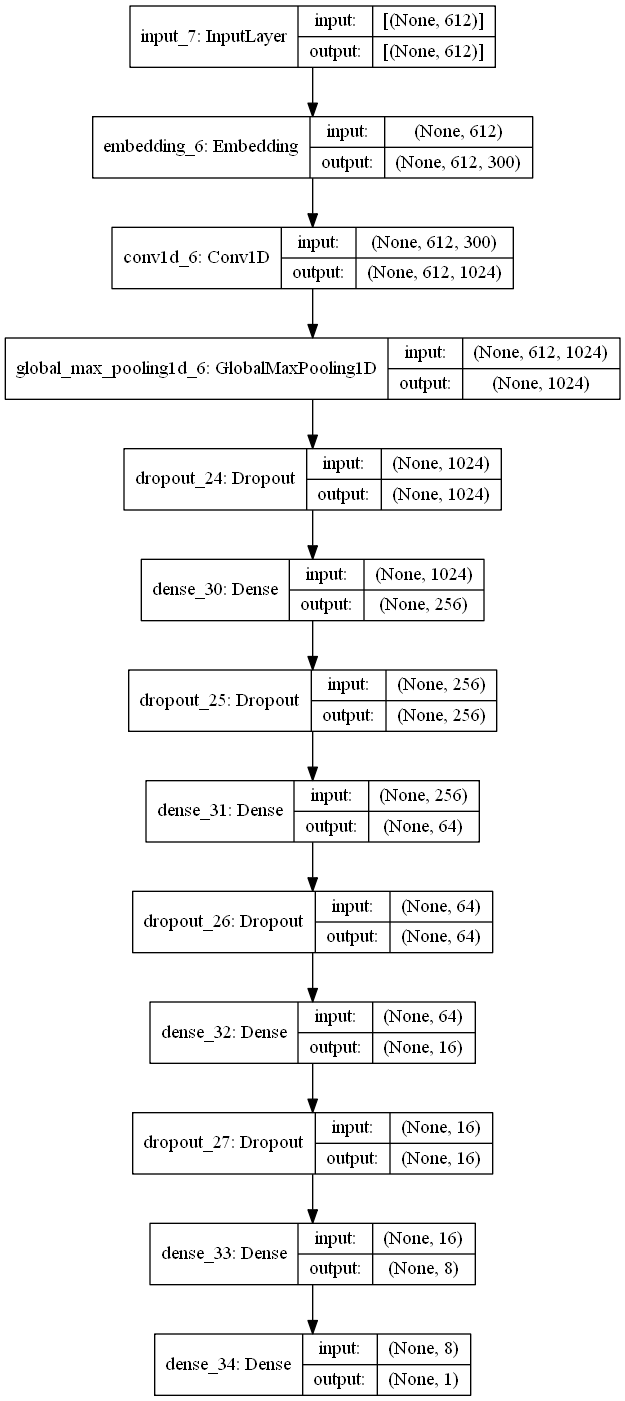

In [31]:
plot_model(tf_native_model,show_shapes=True)

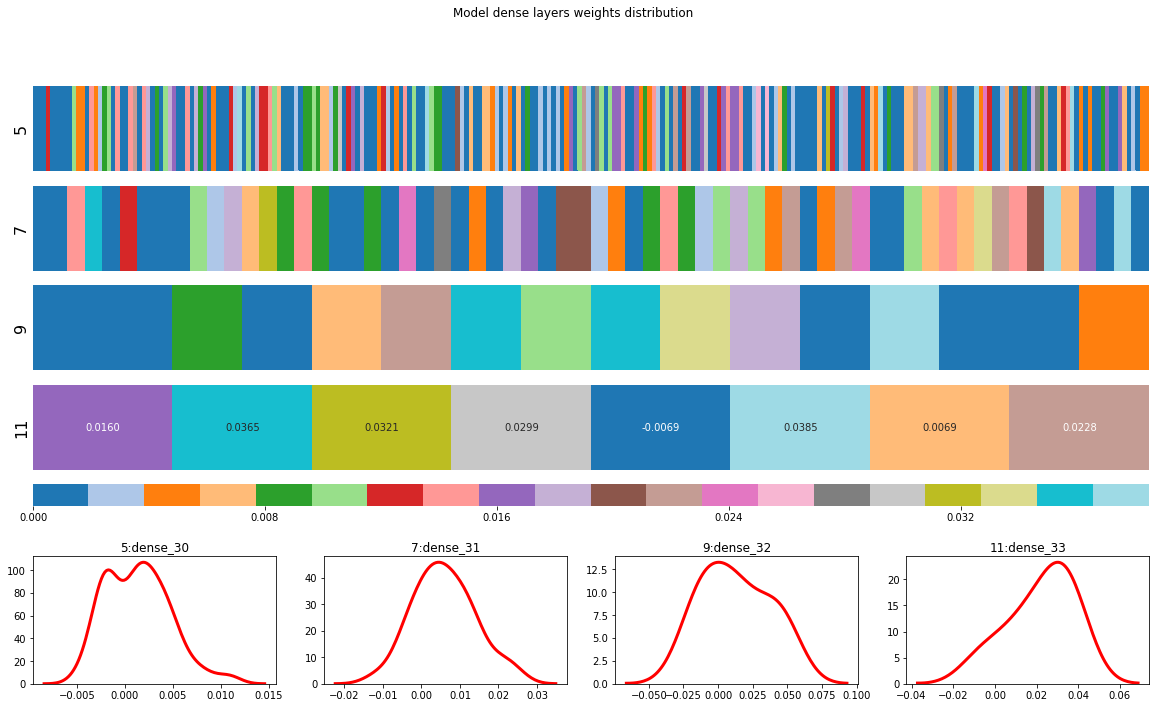

In [64]:

# weights of Dense layers for last iteration
plot_dense_weights_distribution(tf_native_model, [5,7,9,11],(20,11),(2,2,2,2,0.5,0.5,3),'Model dense layers weights distribution')

## Verification of model performance with test set
- the last model is used for evaluation

In [40]:
test_generator=ReviewsGenerator(sequences=padded_sequences_dict['test_seq_pad'],
                                labels=padded_sequences_dict['test_labels'],
                                tokenizer=padded_sequences_dict['tokenizer'], 
                                model=None, 
                                batch_size=100,
                                mode = MODE_TOKENS_ONLY)
predicted=tf_native_model.predict_generator(test_generator)

In [41]:
predicted_sentiment=[1 if x>=0.5 else 0 for x in predicted]

In [42]:
real_sentiment=padded_sequences_dict['test_labels']

In [71]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
print(classification_report(y_true=real_sentiment,y_pred=predicted_sentiment,target_names=['positive','negatice'],digits=4))

              precision    recall  f1-score   support

    positive     0.8951    0.8985    0.8968     12500
    negatice     0.8981    0.8947    0.8964     12500

    accuracy                         0.8966     25000
   macro avg     0.8966    0.8966    0.8966     25000
weighted avg     0.8966    0.8966    0.8966     25000

